# Keras: Time Series Anomaly
***

This Jupyter notebook will contain my submission for the project aspect of the assessment for the Machine Learning & Statistics module (Winter 2022).  
<br>  
The focus of this project will be time-series anomaly detection using Keras. In this notebook, I have recreated and broken down the example code from the [Keras website](https://keras.io/examples/timeseries/timeseries_anomaly_detection/) (with minor changes suggested by the lecturer) into four sections:  
1. Data  
2. Pre-Processing  
3. Neural Network  
4. Evaluation    

Under each section, I will give an overview of what is happening in the code and what the user can expect to see, and aim to clearly explain each Keras function used.  
<br>  
Finally, I suggest some improvements that could be made to the analysis. The notebook concludes with a list of references referred to and consulted in the completing of this project.

<br>

# From Ian's Notebook

***

https://keras.io/examples/timeseries/timeseries_anomaly_detection/

## Evaluation
***

In [1]:
# Numerical arrays
import numpy as np

# Spreadsheet-like Data Frames
import pandas as pd

# Neural networks
import tensorflow.keras as keras

# Plotting
import matplotlib.pyplot as plt

<br>

## 1. Data
***

https://www.kaggle.com/datasets/boltzmannbrain/nab

https://github.com/numenta/NAB

The data used in this project is artificial data taken from the Numenta Anomaly Benchmark (NAB) dataset. Introduced in 2015, NAB is an open source framework comprised of labeled data files which uses a common scoring system "_to compare and evaluate different anomaly detection algorithms for detecting anomalies in streaming data_" [fintelics].

In this section, we will gather the data for the project, import the data into dataframes, check that the data looks OK and do an inital plot of the data so we can take a look at what we're working with.

In [2]:
# Root of URLs
root_url = 'https://raw.githubusercontent.com/numenta/NAB/master/data/'

# Data file without anomaly
no_anomaly_url = root_url + 'artificialNoAnomaly/art_daily_small_noise.csv'

# Data file with anomaly
with_anomaly_url = root_url + 'artificialWithAnomaly/art_daily_jumpsup.csv'

In [3]:
# Checking the no anomaly URL looks OK
no_anomaly_url

'https://raw.githubusercontent.com/numenta/NAB/master/data/artificialNoAnomaly/art_daily_small_noise.csv'

In [4]:
# Checking the with anomaly URL looks OK
with_anomaly_url

'https://raw.githubusercontent.com/numenta/NAB/master/data/artificialWithAnomaly/art_daily_jumpsup.csv'

In [5]:
# Reading the no anomaly data into a data frame called small noise
df_small_noise = pd.read_csv(no_anomaly_url, parse_dates=True, index_col="timestamp")

In [6]:
# Taking a look at the top 5 values in the data frame
df_small_noise.head()

,value
timestamp,
2014-04-01 00:00:00,18.324919
2014-04-01 00:05:00,21.970327
2014-04-01 00:10:00,18.624806
2014-04-01 00:15:00,21.953684
2014-04-01 00:20:00,21.909120


In [7]:
# Using describe to check how many lines are in the data & see some basic stats
df_small_noise.describe()

,value
count,4032.000000
mean,42.438353
std,28.077122
min,18.000964
25%,19.841390
50%,21.608487
75%,75.450282
max,87.976128


In [8]:
# Taking a look at the first value in the data frame
#df_small_noise.iloc[0]
#df_small_noise.iloc[0].values[0]
df_small_noise.iloc[0]['value']

18.3249185392

In [9]:
# Use shape method to see how many values are in the data frame
df_small_noise.shape

(4032, 1)

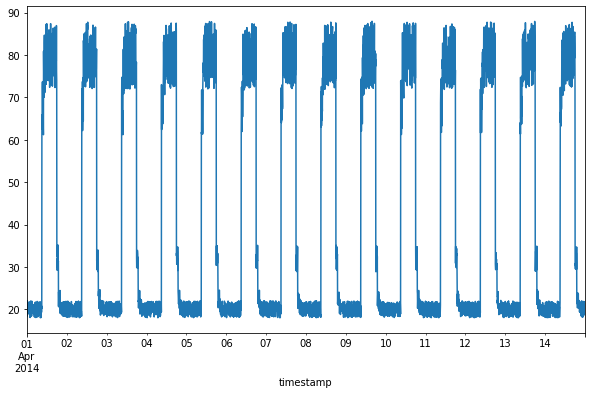

In [10]:
# Creating a subplot
fig, ax = plt.subplots(figsize=(10,6))

# Use pandas to plot the data frame
df_small_noise.plot(legend=False, ax=ax);

In [11]:
# Reading the with anomaly data into a data frame called daily jumpsup
df_daily_jumpsup = pd.read_csv(with_anomaly_url, parse_dates=True, index_col="timestamp")

In [12]:
# Have a look at the top 5 values
df_daily_jumpsup.head()

,value
timestamp,
2014-04-01 00:00:00,19.761252
2014-04-01 00:05:00,20.500833
2014-04-01 00:10:00,19.961641
2014-04-01 00:15:00,21.490266
2014-04-01 00:20:00,20.187739


In [13]:
# Using the describe method to see the no. of values & other basic stats of the date frame
df_daily_jumpsup.describe()

#df_daily_jumpsup.shape

,value
count,4032.000000
mean,44.494254
std,32.432473
min,18.001010
25%,19.991382
50%,21.648503
75%,76.435943
max,164.947481


In [14]:
# Checking the first value in the second data frame
df_daily_jumpsup.iloc[0]['value']

19.761251903

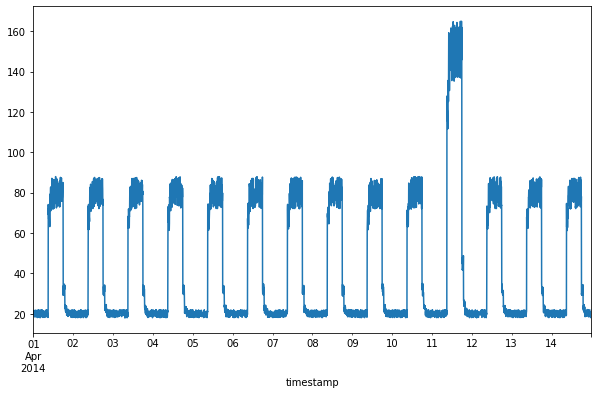

In [15]:
# Creating another subplot
fig, ax = plt.subplots(figsize=(10,6))

# Use pandas to plot the second data frame
df_daily_jumpsup.plot(legend=False, ax=ax);

<br>

## 2. Pre-Processing
***

Here, we prepare the data we are going to use to train the model by doing calculations on the dataset with no anomaly using the mean and standard deviation methods, and storing the data in windows inside a value called x_train.

In [16]:
# get the mean of the no anomaly dataset & store it in var train_mean
train_mean = df_small_noise.mean()

train_mean

value    42.438353
dtype: float64

In [17]:
# get the standard deviation of the no anomaly dataset & store it in var train_std
train_std = df_small_noise.std()

train_std

value    28.077122
dtype: float64

In [18]:
# divide the difference between each no anomaly value & its mean by the standard deviation
# store the result in a new data frame called df_train_vals
df_train_vals = (df_small_noise - train_mean) / train_std

In [19]:
# Take a look at the top 5 values in the new data frame
df_train_vals.head()

,value
timestamp,
2014-04-01 00:00:00,-0.858829
2014-04-01 00:05:00,-0.728993
2014-04-01 00:10:00,-0.848148
2014-04-01 00:15:00,-0.729586
2014-04-01 00:20:00,-0.731173


In [20]:
# add new cols to the no anomaly dataframe containing the value - mean (less_mean) and
# the new less_mean value divided by the standard deviation (div_std)
df_small_noise['less_mean'] = df_small_noise['value'] - df_small_noise['value'].mean()
df_small_noise['div_std'] = df_small_noise['less_mean'] / df_small_noise['value'].std()

In [21]:
# lets see what the no anomaly data frame looks like now
df_small_noise

,value,less_mean,div_std
timestamp,,,
2014-04-01 00:00:00,18.324919,-24.113435,-0.858829
2014-04-01 00:05:00,21.970327,-20.468026,-0.728993
2014-04-01 00:10:00,18.624806,-23.813547,-0.848148
2014-04-01 00:15:00,21.953684,-20.484669,-0.729586
2014-04-01 00:20:00,21.909120,-20.529234,-0.731173
...,...,...,...
2014-04-14 23:35:00,20.211195,-22.227159,-0.791647
2014-04-14 23:40:00,20.531041,-21.907313,-0.780255
2014-04-14 23:45:00,19.032127,-23.406226,-0.833640


In [22]:
# calculate the mean of the value, less_mean and div_std columns in the data frame
df_small_noise['value'].mean(), df_small_noise['less_mean'].mean(), df_small_noise['div_std'].mean()

(42.438353335806646, -7.342627387941552e-14, -2.616541242931684e-15)

In [23]:
# calculate the standard deviation of the value, less_mean and div_std columns in the data frame
df_small_noise['value'].std(), df_small_noise['less_mean'].std(), df_small_noise['div_std'].std()

(28.077122281262515, 28.077122281262508, 1.0000000000000018)

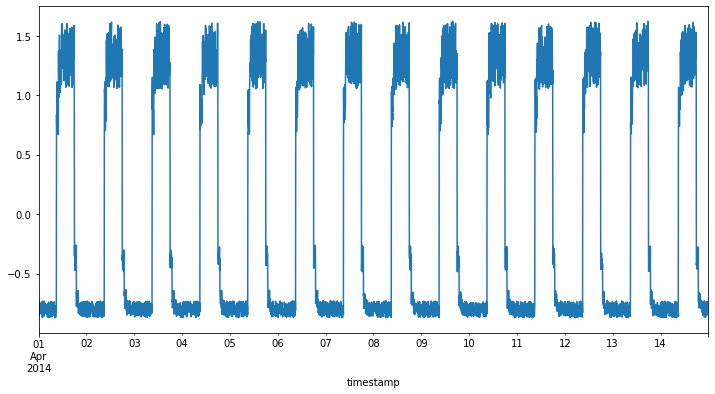

In [24]:
# setting figsize
fig, ax = plt.subplots(figsize=(12,6))

# Plotting the train_vals data frame with pandas
df_train_vals.plot(legend=False, ax=ax);

Compare this plot to the previous one where we plotted df_small_noise (the no anomaly dataset). From a quick glance, the two look the same but upon investigating the values you can see that we have essentially scaled the original values down to be centred around zero, with a standard deviation of approximately 1.

In [25]:
# using shape to see how many values are in the train_vals data frame
df_train_vals.shape

(4032, 1)

In [26]:
# we need to break the train_vals into sequences or "windows" so we can look at each value
# in relation to its peers - here we determine the window size will be 288
window_size = 288

In [27]:
# defining a function to split the data into windows of size 288
def windows(vals, n=window_size):
  # creating a list L to store the windows
  L = []
  # looping through the data up to range 3745 (where the last window begins - 4032-288+1)
  for i in range(len(vals) - n + 1):
    # append each window to L
    L.append(vals[i:i+n])
  # stack method will create a 2D numpy array from L
  return np.stack(L)

In [28]:
# pass the train_vals to the windows function & store result in var x_train
x_train = windows(df_train_vals)

In [29]:
# checking value in first index of first window and last index of last window
x_train[0][0], x_train[-1][-1]

(array([-0.85882857]), array([-0.8460886]))

In [30]:
# checking first and last value in df_train_vals - notice these are the same as above
df_train_vals.iloc[0], df_train_vals.iloc[-1]

(value   -0.858829
 Name: 2014-04-01 00:00:00, dtype: float64,
 value   -0.846089
 Name: 2014-04-14 23:55:00, dtype: float64)

In [31]:
# using shape to check the # of values in x_train
# note that 3745 + 288 -1 = 4032 (the # values in train_vals)
x_train.shape

(3745, 288, 1)

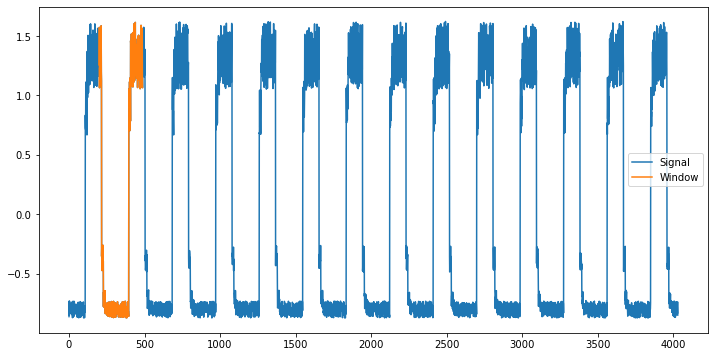

In [34]:
# set value for window number - this will be used as an index below
window_no = 200

# create a subplot and set the figsize
fig, ax = plt.subplots(figsize=(12, 6))

# set y = the values in the train_vals data frame
y = df_train_vals['value'].values

# plot y with label signal
ax.plot(np.arange(y.shape[0]), y, label='Signal')

# set var w = window at index 200 in x_train - flatten will remove the inner arrays
w = x_train[window_no].flatten()

# plot w on top of y with label window
ax.plot(np.arange(w.shape[0]) + window_no, w, label='Window')

# show the legend
ax.legend();

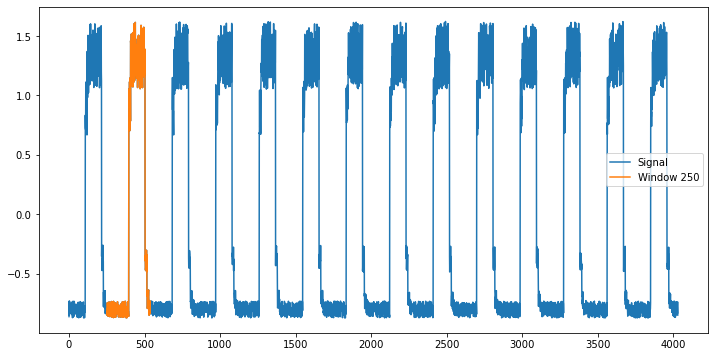

In [35]:
# note that you can change which window gets plotted - see how the orange area moves along the x-axis
window_no = 250

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.arange(y.shape[0]), y, label='Signal')

# set var w = window at index 200 in x_train - flatten will remove the inner arrays
w = x_train[window_no].flatten()

# plot w on top of y with label window
ax.plot(np.arange(w.shape[0]) + window_no, w, label='Window 250')

# show the legend
ax.legend();

<br>

## 3. Neural Network
***

Now that we have our training data, we need to create the neural network for our model. This section is probably the most complicated of all sections in this notebook, so I will spend some time here explaining what is happening at each stage before getting into the code.  
<br>  
We begin building our neural network by defining the layers, which are described as "_the primary building block of Keras models_" by TutotialsPoint, with each layer receiving input, performing some calculation and outputting the result to the next layer []. We can then optimize and compile the model.  
<br>  
The layers can be defined as follows:
##### Input  
- Here's what the [Keras documentation](https://keras.io/api/layers/core_layers/input/) tells us about the input layer:  
"_Input() is used to instantiate a Keras tensor. A Keras tensor is a symbolic tensor-like object, which we augment with certain attributes that allow us to build a Keras model just by knowing the inputs and outputs of the model._"[keras docs]  
- The input layer is literally where we input data into our model. With the input layer, we need to specify the shape of the input data we are going to use to train the model in the form of tuples[wandb], so in our example the input shape has sequence_length of 288 and num_features 1. [keras docs]  

##### Conv1D  
- The next layer applied to our model is called Conv1D. According to [this GitHub post](https://kitchell.github.io/DeepLearningTutorial/4cnnsinkeras.html), the convolutional layer does the 'heavy lifting' within our neural network. In this layer, each filter (32 in our case) is slid (or convolved) along the input, and as this happens an activation or feature map is produced giving the response of the filter at each position. The author goes on to explain that "_the network will learn filters that activate when they see a specific feature, such as edges if the input is an image. Each convolutional layer has multiple filters and each filter produces a separate activation or feature map. These activation maps are stacked together and passed to the next layer._"[kitchell] In our model we are using a one dimensional Convolutional Layer, but 2D versions also exist.  
- Note that when we create the Conv1D layer, we use the parameter activation="relu", which stands for rectified linear unit. In their blogpost, kitchell tells us that relu sets all negative pixels or elements of the activation to zero, which introduces non-linearity into the data to make it more like real-life data, and helps to balance out the linear convolution process.[kitchell]  
<br>  
  
##### Dropout  
- The dropout layer is next. Jason Brownlee at machinelearningmastery.com tells us that dropout is a regularization technique for neural networks in which randomly selected neurons are ignored (or "dropped off") during training. [mlm dropout] It is not used when evaluating the model. [mlm dropout] The contribution of the dropped neurons to the activation of downstream neurons is temporally disabled on the forward pass, and any affect on the weights is not applied on the backward pass.[projectpro]  
- Brownlee provides the following explanation on the effect of the dropout technique:  
"_As a neural network learns, neuron weights settle into their context within the network. Weights of neurons are tuned for specific features, providing some specialization. Neighboring neurons come to rely on this specialization, which, if taken too far, can result in a fragile model too specialized for the training data. This reliance on context for a neuron during training is referred to as complex co-adaptations.  
You can imagine that if neurons are randomly dropped out of the network during training, other neurons will have to step in and handle the representation required to make predictions for the missing neurons. This is believed to result in multiple independent internal representations being learned by the network.  
The effect is that the network becomes less sensitive to the specific weights of neurons. This, in turn, results in a network capable of better generalization and less likely to overfit the training data._"[mlm dropout]  
- In our model, we are using a dropout rate of 0.2. After this layer has been applied, another Conv1D layer is created, with 16 filters this time.  
<br>  

##### Conv1DTranspose  
- After the second Conv1D layer has been applied to the model, we then add a Conv1DTranspose layer. Here's what the [Keras documentation](https://keras.io/api/layers/core_layers/input/) tells us about this layer:  
"_Transposed convolution layer (sometimes called Deconvolution).The need for transposed convolutions generally arises from the desire to use a transformation going in the opposite direction of a normal convolution, i.e., from something that has the shape of the output of some convolution to something that has the shape of its input while maintaining a connectivity pattern that is compatible with said convolution._"  
- This was the layer I found most difficult to understand, but based on the definition cited above and my understanding of how transpose works in Excel, I take it that in this step we are flipping the data that has been passed in the previous Conv1D step on it's head before it get's passed to the next layer.  
- Following this step, a second dropout layer is applied to the model, followed by two more Conv1DTranspose layers.  
<br>  

Once the layers have been defined, we can then create our model by passing the layers to Keras. In this example, we use a sequential model. The idea is that the layers we pass to the model are arranged in order (sequence) with the data flowing from one layer to the next until it reaches the output layer. [https://www.tutorialspoint.com/keras/keras_models.htm]  
<br>  

The next step is optimization. The optimizer or optimization algorithm is the logic which the neural network uses to decide how much adjustment is needed on the weights on the nodes to solve the problem at hand, based on the difference between the training data and the results observed. [https://www.kaggle.com/code/residentmario/keras-optimizers]. We will use an optimizer called Adam, whose name is devired from adaptive moment estimation. [keras same]. While Adam is a form of stochastic gradient descent, it differs from the classical interpretation as the learning rate of the optimizer can adapt and do at different rates for each eight as learning unfolds. [mlmadam]  
<br>  

Finally, with the layers, model type and optimizer defined, the last step is to choose a loss function for our model. The purpose of the loss function is to evaluate the weights and aim to minimize the error (or loss), with less error equating to a more accurate neural network. [dataflair] The loss function we will use is called mse (mean squared error) and is calculated as the average of the squared differences between the predicted and actual values. [mlm htcl] This particular loss function punishes larger errors  more than small ones. [neptune]  
<br>  

We can then compile our model and take a look at it's summary information, before training the model. In training, we use x_train as both the input and the output (as we are using is a reconstruction model)[https://keras.io/examples/timeseries/timeseries_anomaly_detection/], and set epochs, which is number of times we want the model to be evaluated during training to 50 and batch size (the number of training instances) to 128. We also pass the argument validation_split=0.1, which according to the [offical Keras documentation](https://keras.io/api/models/model_training_apis/) is a "_fraction of the training data to be used as validation data. The model will set apart this fraction of the training data, will not train on it, and will evaluate the loss and any model metrics on this data at the end of each epoch._"[tpkmc].  
<br>  

The final argument we use in the training step is callbacks, with the class EarlyStopping, and we pass the following arguments: monitor="val_loss", patience=5, mode="min". With this argument, we are telling the model that it can stop the training when a monitored metric has stopped improving, and in this case we are telling it monitor the quantity of "val_loss", with patience (the number of epochs after which to stop the training if there is no improvement) set to 5 mode set to min, meaning training will stop when val_loss has stopped decreasing. [keras callbacks]  
<br>

Now, let's get into the code.  

<br>

In [36]:
# let's look at the shape of our training data again - we'll use this in the input layer
x_train.shape

(3745, 288, 1)

In [1]:
# defining the layers of our neural network
layers = [
  # input will be 288 (sequence length) & 1 (num_features) -> index 1 and 2 of the shape value above
  keras.layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
  # 1st Conv1D layer with 32 filters and stride (paces to slide along data) of 2
  keras.layers.Conv1D(
    filters=32, kernel_size=7, padding="same", strides=2, activation="relu"),
  # 1st dropout layer - ignoring/dropping off 2% of the neurons in the data
  keras.layers.Dropout(rate=0.2),
  # 2nd Conv1D layer - 16 filters this time but same stride
  keras.layers.Conv1D(
    filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),
  # 1st Conv1DTranspose layer where data is essentially flipped
  keras.layers.Conv1DTranspose(
    filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),
  # 2nd dropout layer, same rate
  keras.layers.Dropout(rate=0.2),
  # 2nd Conv1DTranspose layer
  keras.layers.Conv1DTranspose(
    filters=32, kernel_size=7, padding="same", strides=2, activation="relu"),
  # 3rd Conv1DTranspose layer
  keras.layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
]

NameError: name 'keras' is not defined

In [38]:
# passing the layers to keras to create a sequential model
model = keras.Sequential(layers)

In [39]:
# using the Adam optimizer with learning rate 0.001 (this is the default learning rate)
optimizer = keras.optimizers.Adam(learning_rate=0.001)

In [40]:
# compiling the module with our Adam optimizer & mean squared error loss function
model.compile(optimizer=optimizer, loss="mse")

In [41]:
# summary of our model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 144, 32)           256       
                                                                 
 dropout (Dropout)           (None, 144, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 72, 16)            3600      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 144, 16)          1808      
 nspose)                                                         
                                                                 
 dropout_1 (Dropout)         (None, 144, 16)           0         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 288, 32)          3616      
 ranspose)                                              

In [42]:
# training the model
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
27/27 [==============================] - 7s 112ms/step - loss: 0.4146 - val_loss: 0.0625
Epoch 2/50
27/27 [==============================] - 2s 86ms/step - loss: 0.0752 - val_loss: 0.0450
Epoch 3/50
27/27 [==============================] - 2s 87ms/step - loss: 0.0562 - val_loss: 0.0350
Epoch 4/50
27/27 [==============================] - 2s 87ms/step - loss: 0.0477 - val_loss: 0.0313
Epoch 5/50
27/27 [==============================] - 2s 86ms/step - loss: 0.0419 - val_loss: 0.0274
Epoch 6/50
27/27 [==============================] - 2s 86ms/step - loss: 0.0370 - val_loss: 0.0239
Epoch 7/50
27/27 [==============================] - 2s 85ms/step - loss: 0.0332 - val_loss: 0.0225
Epoch 8/50
27/27 [==============================] - 2s 82ms/step - loss: 0.0302 - val_loss: 0.0207
Epoch 9/50
27/27 [==============================] - 2s 83ms/step - loss: 0.0278 - val_loss: 0.0203
Epoch 10/50
27/27 [==============================] - 2s 83ms/step - loss: 0.0260 - val_loss: 0.0191
Epoch 11

<br>

## 4. Evaluation
***

In [43]:
history.history["loss"]

[0.4145907759666443,
 0.0752328410744667,
 0.05616191029548645,
 0.047728944569826126,
 0.04186296463012695,
 0.036971546709537506,
 0.03316342830657959,
 0.03021041676402092,
 0.027822298929095268,
 0.02603631466627121,
 0.024493716657161713,
 0.023353826254606247,
 0.02222273126244545,
 0.021276837214827538,
 0.02044427953660488]

In [44]:
history.history["val_loss"]

[0.06245517358183861,
 0.04495708644390106,
 0.03501144051551819,
 0.03126842901110649,
 0.02744377963244915,
 0.02387864701449871,
 0.022505884990096092,
 0.02071971446275711,
 0.020263129845261574,
 0.01908019930124283,
 0.020207837224006653,
 0.020106825977563858,
 0.0194094255566597,
 0.020447710528969765,
 0.02142021618783474]

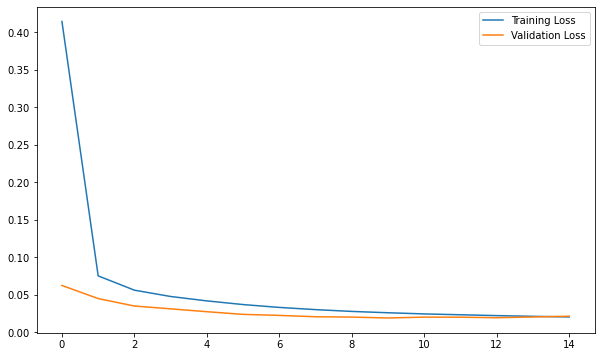

In [45]:
# 
fig, ax = plt.subplots(figsize=(10, 6))
# 
ax.plot(history.history["loss"], label="Training Loss")
# 
ax.plot(history.history["val_loss"], label="Validation Loss")
# 
ax.legend();

In [46]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)

118/118 [==============================] - 2s 13ms/step


In [47]:
# Calculate loss...
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

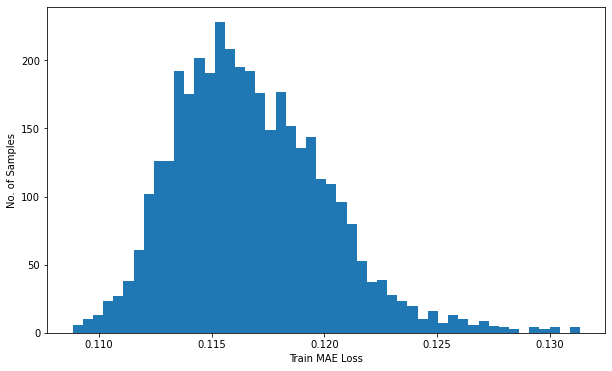

In [48]:
# 
fig, ax = plt.subplots(figsize=(10, 6))
# 
ax.hist(train_mae_loss, bins=50)
# 
ax.set_xlabel("Train MAE Loss")
#
ax.set_ylabel("No. of Samples");

In [49]:
# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)

# 
threshold

0.13135062508687226

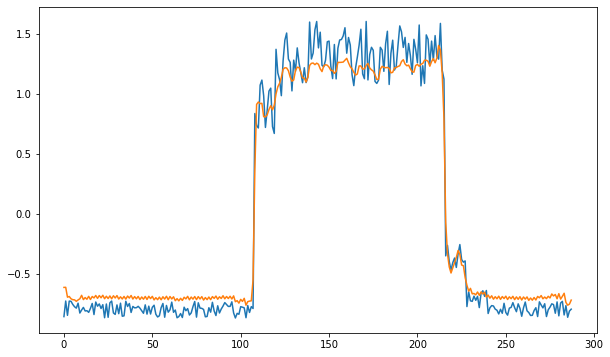

In [50]:
# 
fig, ax = plt.subplots(figsize=(10, 6))

# 
ax.plot(x_train[0])

# 
ax.plot(x_train_pred[0]);

In [51]:
# 
df_test_value = (df_daily_jumpsup - train_mean) / train_std

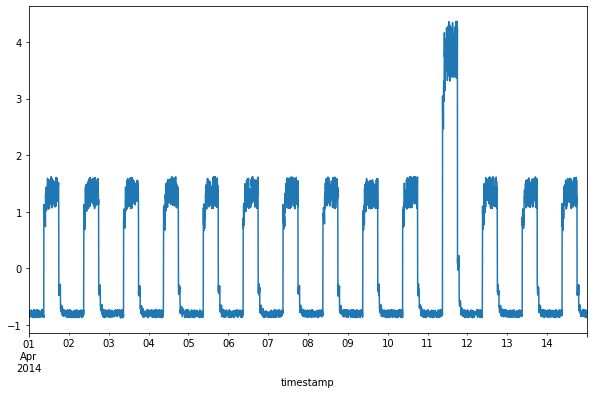

In [52]:
# 
fig, ax = plt.subplots(figsize=(10, 6))

# 
df_test_value.plot(legend=False, ax=ax);

In [53]:
# Create sequences from test values.
x_test = windows(df_test_value.values)

x_test.shape

(3745, 288, 1)

In [54]:
# 
x_test_pred = model.predict(x_test)

118/118 [==============================] - 2s 13ms/step


In [55]:
# 
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)

test_mae_loss

array([[0.11121328],
       [0.11222807],
       [0.11102463],
       ...,
       [0.11343133],
       [0.11431511],
       [0.10970784]])

In [56]:
# 
test_mae_loss = test_mae_loss.reshape((-1))

test_mae_loss

array([0.11121328, 0.11222807, 0.11102463, ..., 0.11343133, 0.11431511,
       0.10970784])

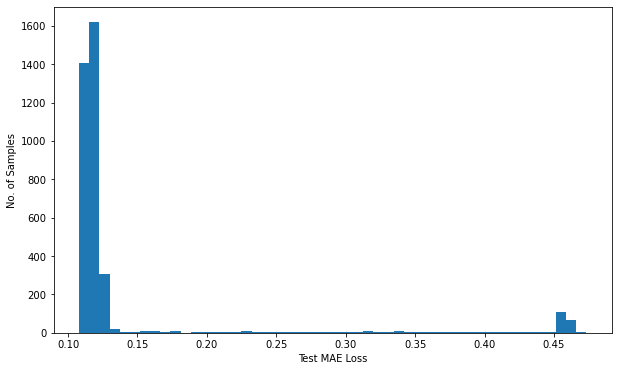

In [57]:
# 
fig, ax = plt.subplots(figsize=(10, 6))

#
ax.hist(test_mae_loss, bins=50)

# 
ax.set_xlabel("Test MAE Loss")

# 
ax.set_ylabel("No. of Samples");

In [58]:
# Detect all the samples which are anomalies
anomalies = test_mae_loss > threshold

# Number of anomalies
np.sum(anomalies)

405

In [59]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
inds = []

for i in range(window_size - 1, len(df_test_value) - window_size + 1):
    if np.all(anomalies[i - window_size + 1 : i]):
        inds.append(i)

In [60]:
# 
df_subset = df_daily_jumpsup.iloc[inds]

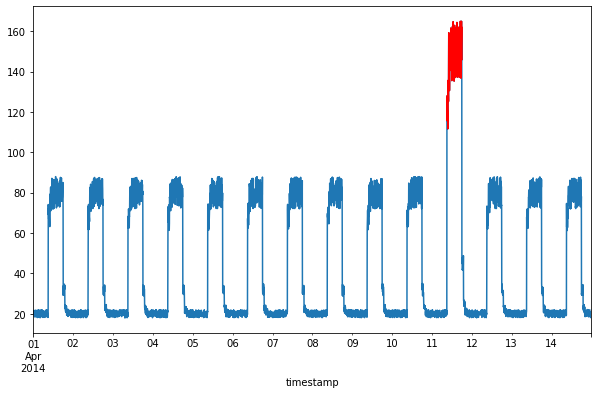

In [61]:
#
fig, ax = plt.subplots(figsize=(10, 6))

# 
df_daily_jumpsup.plot(legend=False, ax=ax)

# 
df_subset.plot(legend=False, ax=ax, color="r");

<br>

## Conclusion
***

In conclusion....

<br>

## References
***

[] https://data-flair.training/blogs/keras-loss-functions/  
[] https://fintelics.medium.com/everything-you-need-to-know-about-numenta-anomaly-benchmark-nab-b43ab7f014df  
[] https://www.kaggle.com/code/residentmario/keras-optimizers  
[] https://www.kaggle.com/datasets/boltzmannbrain/nab  
[] https://keras.io/api/callbacks/early_stopping/  
[] https://keras.io/api/models/model_training_apis/  
[] https://keras.io/examples/timeseries/timeseries_anomaly_detection/  
[] https://keras.io/api/layers/core_layers/input/  
[] https://kitchell.github.io/DeepLearningTutorial/4cnnsinkeras.html  
[] https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/  
[] https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/  
[] https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/  
[] https://machinelearningmastery.com/lstm-autoencoders/  
[] https://medium.com/towards-artificial-intelligence/autoencoder-for-anomaly-detection-using-tensorflow-keras-7fdfa9f3ad99  
[] https://neptune.ai/blog/keras-loss-functions  
[] https://www.projectpro.io/recipes/what-is-drop-out-rate-keras  
[] https://towardsdatascience.com/time-series-of-price-anomaly-detection-with-lstm-11a12ba4f6d9  
[] https://www.tutorialspoint.com/keras/keras_layers.htm  
[] https://www.tutorialspoint.com/keras/keras_model_compilation.htm  
[] https://www.tutorialspoint.com/keras/keras_models.htm  
[] https://wandb.ai/ayush-thakur/dl-question-bank/reports/Keras-Layer-Input-Explanation-With-Code-Samples--VmlldzoyMDIzMDU  

<br>

# End
***